In [1]:
import os
import tarfile
import shutil
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm
from transformers import CLIPProcessor, CLIPModel

In [2]:
# ----------------------------------------------------
def mount_drive():
    """Mount Google Drive into Colab"""
    drive.mount('/content/drive')
    print("✅ Google Drive mounted.")

# ----------------------------------------------------
def extract_dataset(tar_path, extract_to='./'):
    """Extracts a .tar file if the destination folder doesn't already exist"""
    dataset_folder = os.path.join(extract_to, 'ip102_v1.1')

    if not os.path.exists(dataset_folder):
        print("📦 Extracting dataset...")
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(path=extract_to)
        print("✅ Dataset extracted to:", dataset_folder)
    else:
        print("✅ Dataset already extracted. Skipping.")

# ----------------------------------------------------
def copy_classes_file(src_path, dst_path='./classes.txt'):
    """Copies classes.txt if not already present"""
    if not os.path.exists(dst_path):
        shutil.copy(src_path, dst_path)
        print("✅ classes.txt copied to current directory.")
    else:
        print("✅ classes.txt already exists. Skipping copy.")

# ----------------------------------------------------
def copy_prompts_file(src_path, dst_path):
    """Copies classes.txt if not already present"""
    if not os.path.exists(dst_path):
        shutil.copy(src_path, dst_path)
        print("✅ classes.txt copied to current directory.")
    else:
        print("✅ classes.txt already exists. Skipping copy.")

In [3]:
# mount_drive()
#from google.colab import drive
# tar_path = '/content/drive/MyDrive/PEST-DS/ip102_v1.1.tar'
# classes_txt_src = '/content/drive/MyDrive/PEST-DS/classes.txt'
# prompt_gpt_src = '/content/drive/MyDrive/prompt_gpt.txt'
# prompt_gemini_src = '/content/drive/MyDrive/prompt_gemini.txt'
# prompt_moah_src = '/content/drive/MyDrive/simple prompt.txt'

# extract_dataset(tar_path)
# copy_classes_file(classes_txt_src)
# copy_prompts_file(prompt_gpt_src, './prompt_gpt.txt')
# copy_prompts_file(prompt_gemini_src, './prompt_gemini.txt')
# copy_prompts_file(prompt_moah_src, './simple prompt.txt')

In [4]:
class Constants:
    ## PATHs ##
    DATASET_ROOT = './ip102_v1.1/'
    IMG_ROOT = os.path.join(DATASET_ROOT, "images")
    TRAIN_PATH = os.path.join(DATASET_ROOT, "train.txt")
    VAL_PATH = os.path.join(DATASET_ROOT, "val.txt")
    TEST_PATH = os.path.join(DATASET_ROOT, "test.txt")
    ID_CLASSES_PATH = os.path.join('./', "classes.txt")
    PROMPT_GEMINI = os.path.join('./', "prompt_gemini.txt")
    PROMPT_GPT = os.path.join('./', "prompt_gpt.txt")
    PROMPT_MOAH = os.path.join('./', "simple prompt.txt")
    BATCH_SIZE = 16
    SHUFFLE = True

In [5]:
import numpy as np
import os
from torch.utils.data import Dataset
from PIL import Image

## Get Path of .txt file path,label like: 75219.jpg 101
## returns array of tuples in (path, label)
def load_split_file(file_path):
    with open(file_path, 'r') as f:
        samples = np.array(
            [(path, int(label)) for path, label in (line.strip().split() for line in f)],
            dtype=object
        )
    return samples

def load_txt_file(file_path):
    with open(file_path, 'r') as f:
      lines = f.readlines()
    return lines

def load_classes(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    classes = []
    ids = []
    for line in lines:
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            id_str, label = parts
            id = int(id_str)
            ids.append(id)
            classes.append(label)
    return ids, classes

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image2class_path, transform=None):
        self.data_list = load_split_file(image2class_path)
        self.root_dir = Constants.IMG_ROOT
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        image_path = os.path.join(self.root_dir, path)
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format

        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomImageDataset(Constants.TRAIN_PATH, transform=transform)
val_dataset = CustomImageDataset(Constants.VAL_PATH, transform=transform)
test_dataset = CustomImageDataset(Constants.TEST_PATH, transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=Constants.BATCH_SIZE, shuffle=Constants.SHUFFLE)
val_loader = DataLoader(val_dataset, batch_size=Constants.BATCH_SIZE, shuffle=Constants.SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=Constants.BATCH_SIZE, shuffle=Constants.SHUFFLE)

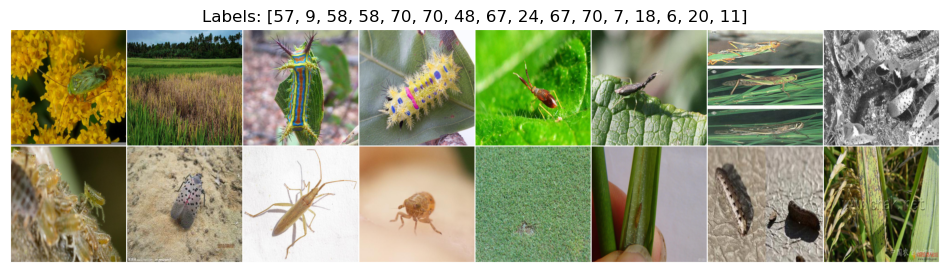

In [10]:
images, labels = next(iter(train_loader))

# Make a grid of images
grid = make_grid(images, nrow=8, normalize=True, pad_value=1)

# Convert to numpy for plotting
npimg = grid.permute(1, 2, 0).numpy()

# Plot the grid
plt.figure(figsize=(12, 6))
plt.imshow(npimg)
plt.title(f"Labels: {labels.tolist()}")
plt.axis("off")
plt.show()

In [11]:
import re

def load_prompts_by_class(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    entries = re.split(r'\n(?=\*\*\d+\.\s)', content)
    prompts = []

    for entry in entries:
        match = re.match(r'\*\*(\d+)\.\s(.*?)\*\*\n(.*)', entry.strip(), re.DOTALL)
        if match:
            class_id, title, description = match.groups()
            full_prompt = f"{title}. {description.strip()}"
            prompts.append(full_prompt)
        else:
            print(f"⚠️ Couldn't parse entry:\n{entry[:100]}")

    assert len(prompts) == 102, f"Expected 102 prompts, got {len(prompts)}"
    return prompts

In [ ]:
def load_markdown_style_prompts(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    entries = re.split(r'\n(?=###\s\d+\.\s)', content.strip())
    prompts = []

    for entry in entries:
        lines = entry.strip().split('\n')
        if not lines or not lines[0].startswith('###'):
            continue
        
        title_match = re.match(r'###\s*(\d+)\.\s+(.*)', lines[0])
        if not title_match:
            print(f"⚠️ Couldn't parse entry title:\n{lines[0]}")
            continue
        number, title = title_match.groups()

        body = '\n'.join(lines[1:]).strip()

        bold_match = re.match(r'\*\*(.*?)\*\*\s*[,:\-–—]?\s*(.*)', body, re.DOTALL)
        if bold_match:
            bold_title, description = bold_match.groups()
            full_title = bold_title.strip()
        else:
            full_title = title.strip()
            description = body.strip()

        prompt = f"{full_title}. {description}"
        prompts.append(prompt)

    assert len(prompts) == 102, f"Expected 102 prompts, got {len(prompts)}"
    return prompts

In [25]:
ids, classes = load_classes(Constants.ID_CLASSES_PATH)

In [26]:
prompt_gemini = load_markdown_style_prompts(Constants.PROMPT_GEMINI)
prompt_gpt = load_prompts_by_class(Constants.PROMPT_GPT)
#prompt_moah = load_txt_file(Constants.PROMPT_MOAH)

In [27]:
# SETTINGS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use CLIP model which is better for zero-shot classification
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)
model.eval()

print(f"Loaded model: {model_name}")
print(f"Number of classes: {len(classes)}")

# Create class prompts for better classification
#class_prompts = [f"a photo of {class_name}" for class_name in classes]
class_prompts = prompt_gemini
print("Computing class embeddings...")
# Compute text embeddings for all classes
with torch.no_grad():
    text_inputs = processor(text=class_prompts, return_tensors="pt", padding=True, truncation=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    text_features = model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize

print(f"Text features shape: {text_features.shape}")

# Validation function
def evaluate_model(data_loader, text_features, model, processor, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc="Evaluating")):
            # Convert tensor images back to PIL for processor
            if isinstance(images, torch.Tensor):
                images_pil = []
                for img_tensor in images:
                    # Convert tensor to PIL
                    img_pil = transforms.ToPILImage()(img_tensor)
                    images_pil.append(img_pil)
                images = images_pil

            labels = labels.to(device)

            # Process images
            image_inputs = processor(images=images, return_tensors="pt", padding=True)
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

            # Get image features
            image_features = model.get_image_features(**image_inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize

            # Compute similarities (cosine similarity)
            similarities = torch.matmul(image_features, text_features.T)

            # Get predictions
            predictions = torch.argmax(similarities, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels

# Run validation
print("Starting validation...")
val_accuracy, val_preds, val_labels = evaluate_model(val_loader, text_features, model, processor, device)

# Run test
print("Starting Testing...")
test_accuracy, test_preds, test_labels = evaluate_model(test_loader, text_features, model, processor, device)

print(f"✅ Validation Accuracy: {val_accuracy:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

Using device: cuda
Loaded model: openai/clip-vit-base-patch32
Number of classes: 102
Computing class embeddings...
Text features shape: torch.Size([102, 512])
Starting validation...


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]

Starting Testing...


Evaluating:   0%|          | 0/1414 [00:00<?, ?it/s]

✅ Validation Accuracy: 0.1368
✅ Test Accuracy: 0.1311


In [16]:
# # Optional: Show some classification results
# print("\nSample predictions:")
# for i in range(min(10, len(val_preds))):
#     print(val_preds[i])
#     pred_class = classes[val_preds[i]] if val_preds[i] < len(classes) else "Unknown"
#     true_class = classes[val_labels[i]] if val_labels[i] < len(classes) else "Unknown"
#     print(f"Predicted: {pred_class}, True: {true_class}")